## Problem Statement

The goal of this project is to use a bunch of news articles extracted from the companies’ internal database and categorize them into several categories like politics, technology, sports, business and entertainment based on their content. Use natural language processing and create & compare at least three different models.

## Importing the libraries & Reading the data file

### Importing all the required libraries

In [1]:
import os
import re
import random
import string

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet          
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import spacy

In [5]:
from pprint import pprint
import contractions

In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [7]:
from tqdm.notebook import tqdm

### Loading the dataset

In [8]:
news_articles = pd.read_csv('flipitnews-data.csv')
news_articles

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,Business,cars pull down us retail figures us retail sal...
2221,Politics,kilroy unveils immigration policy ex-chatshow ...
2222,Entertainment,rem announce new glasgow concert us band rem h...
2223,Politics,how political squabbles snowball it s become c...


## Exploring the dataset

In [9]:
news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Article   2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [10]:
print("Shape of dataset : {}".format(news_articles.shape))

Shape of dataset : (2225, 2)


In [11]:
np.unique(news_articles.duplicated())

array([False,  True])

In [12]:
# duplicate rows in dataset
news_articles[news_articles.duplicated()]

,Category,Article
85,Politics,hague given up his pm ambition former conser...
301,Politics,fox attacks blair s tory lies tony blair lie...
496,Technology,microsoft gets the blogging bug software giant...
543,Business,economy strong in election year uk businesse...
582,Entertainment,ray dvd beats box office takings oscar-nominat...
...,...,...
2206,Politics,kennedy questions trust of blair lib dem leade...
2207,Technology,california sets fines for spyware the makers o...
2213,Technology,progress on new internet domains by early 2005...
2215,Technology,junk e-mails on relentless rise spam traffic i...


In [13]:
# printing one article from duplicates
news_articles['Article'].iloc[85]

'hague  given up  his pm ambition former conservative leader william hague says he will not stand for the leadership again  having given up his ambition to be prime minister.  mr hague  43  told the daily telegraph he would now find a life dominated by politics too  boring  and unfulfilling. mr hague  who stepped down after his party s 2001 election defeat  does not rule out a return to the front bench. he also told the paper he hopes to remain mp for richmond  north yorks  and start a family with wife ffion. mr hague  who recently had published the biography of william pitt the younger  also said he wanted to continue writing books and speech-writing.  he told the newspaper:  i don t know whether i will ever go back on to the front  but don t rush me.  asked if he would stand for the leadership again  mr hague replied:  no. definitely not.  his determination to stay away from a central role will disappoint some senior conservative members  who say the party needs him. tim collins  the

In [14]:
# checking one example of duplicate
news_articles.loc[news_articles['Article'] == news_articles['Article'].iloc[85]]

,Category,Article
13,Politics,hague given up his pm ambition former conser...
85,Politics,hague given up his pm ambition former conser...


In [15]:
news_articles = news_articles.drop_duplicates(ignore_index=True)

In [16]:
news_articles

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2121,Business,cars pull down us retail figures us retail sal...
2122,Politics,kilroy unveils immigration policy ex-chatshow ...
2123,Entertainment,rem announce new glasgow concert us band rem h...
2124,Politics,how political squabbles snowball it s become c...


### Shape of the dataset

In [17]:
print("Shape of dataset : {}".format(news_articles.shape))

Shape of dataset : (2126, 2)


In [18]:
class_names = np.sort(news_articles['Category'].unique())
print('class_names :', class_names)

class_names : ['Business' 'Entertainment' 'Politics' 'Sports' 'Technology']


In [19]:
news_articles['Category'].value_counts()

Category
Sports           504
Business         503
Politics         403
Entertainment    369
Technology       347
Name: count, dtype: int64

### News articles per category

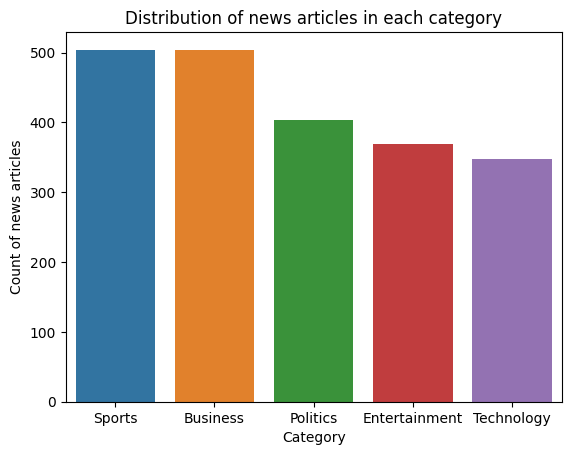

In [20]:
sns.countplot(data=news_articles, x='Category', order=news_articles['Category'].value_counts().index)
plt.ylabel('Count of news articles')
plt.title('Distribution of news articles in each category')
plt.show()

## Processing the Textual Data (the news articles)

In [21]:
# Get the stopwords for English
stopwords_english = stopwords.words('english')

# Print the stopwords
print(stopwords_english)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
def process_article_NLTK(article_text):       
    # Step 1: Remove non-letters
    article_text = re.sub(r'[^a-zA-Z]', ' ', article_text)
    
    # Step 2: Tokenize the text
    tokens = word_tokenize(article_text)
    
    # Step 3: Remove stopwords
    stopwords_english = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stopwords_english and len(token)>2]
    
    # Step 4: Lemmatization
    # lemmatizer = WordNetLemmatizer()
    # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return ' '.join(filtered_tokens)

In [23]:
def process_article_spaCy(article_text):
    # NLP processing pipeline
    nlp = spacy.load("en_core_web_sm")
    
    # applying NLP object on text data
    tokens = nlp(article_text)
    
    # Step 4: Lemmatization
    lemmatized_tokens = [token.lemma_ if token.pos_ in ['VERB', 'NOUN', 'ADJ'] else token.text for token in tokens \
                         if token.is_alpha and not token.is_digit and not token.is_punct and not token.is_stop]
    
    return ' '.join(lemmatized_tokens)

In [24]:
print(process_article_spaCy("Alphabet sb child companies Apple is looking at buying U.K. startups for $1 billion"))

Alphabet sb child company Apple look buy startup billion


In [25]:
print(process_article_NLTK(process_article_spaCy("Alphabet sb child companies Apple is looking at buying U.K. startups for $1 billion")))

Alphabet child company Apple look buy startup billion


In [26]:
text = news_articles['Article'][4]
print(text)

ocean s twelve raids box office ocean s twelve  the crime caper sequel starring george clooney  brad pitt and julia roberts  has gone straight to number one in the us box office chart.  it took $40.8m (£21m) in weekend ticket sales  according to studio estimates. the sequel follows the master criminals as they try to pull off three major heists across europe. it knocked last week s number one  national treasure  into third place. wesley snipes  blade: trinity was in second  taking $16.1m (£8.4m). rounding out the top five was animated fable the polar express  starring tom hanks  and festive comedy christmas with the kranks.  ocean s twelve box office triumph marks the fourth-biggest opening for a december release in the us  after the three films in the lord of the rings trilogy. the sequel narrowly beat its 2001 predecessor  ocean s eleven which took $38.1m (£19.8m) on its opening weekend and $184m (£95.8m) in total. a remake of the 1960s film  starring frank sinatra and the rat pack  

In [27]:
print(process_article_spaCy(text))

ocean s raid box office ocean s crime caper sequel star george clooney brad pitt julia roberts go straight number box office chart take m m weekend ticket sale accord studio estimate sequel follow master criminal try pull major heist europe knock week s number national treasure place wesley snipe blade trinity second take m m round animate fable polar express star tom hank festive comedy christmas krank ocean s box office triumph mark fourth big opening december release film lord ring trilogy sequel narrowly beat predecessor ocean s take m m opening weekend m m total remake film star frank sinatra rat pack ocean s direct oscar win director steven soderbergh soderbergh return direct hit sequel reunite clooney pitt roberts matt damon andy garcia elliott gould catherine zeta jones join star cast s fun good holiday movie say dan fellman president distribution warner bros critic complimentary m m project los angeles time label dispirit vanity project milder review new york times dub sequel 

In [28]:
print(process_article_NLTK(process_article_spaCy(text)))

ocean raid box office ocean crime caper sequel star george clooney brad pitt julia roberts straight number box office chart take weekend ticket sale accord studio estimate sequel follow master criminal try pull major heist europe knock week number national treasure place wesley snipe blade trinity second take round animate fable polar express star tom hank festive comedy christmas krank ocean box office triumph mark fourth big opening december release film lord ring trilogy sequel narrowly beat predecessor ocean take opening weekend total remake film star frank sinatra rat pack ocean direct oscar win director steven soderbergh soderbergh return direct hit sequel reunite clooney pitt roberts matt damon andy garcia elliott gould catherine zeta jones join star cast fun good holiday movie say dan fellman president distribution warner bros critic complimentary project los angeles time label dispirit vanity project milder review new york times dub sequel unabashedly trivial


In [29]:
processed_news_articles = news_articles.copy()

In [30]:
tqdm.pandas(desc="Processing news articles using spaCy") 
processed_news_articles['Article'] = processed_news_articles['Article'].progress_apply(process_article_spaCy)
tqdm.pandas(desc="Processing news articles using NLTK") 
processed_news_articles['Article'] = processed_news_articles['Article'].progress_apply(process_article_NLTK)

Processing news articles using spaCy:   0%|          | 0/2126 [00:00<?, ?it/s]

Processing news articles using NLTK:   0%|          | 0/2126 [00:00<?, ?it/s]

In [31]:
processed_news_articles

,Category,Article
0,Technology,future hand viewer home theatre system plasma ...
1,Business,worldcom boss leave book worldcom boss bernie ...
2,Sports,tiger wary farrell gamble leicester rush make ...
3,Sports,yeade face newcastle cup premiership newcastle...
4,Entertainment,ocean raid box office ocean crime caper sequel...
...,...,...
2121,Business,car pull retail figure retail sale fall januar...
2122,Politics,kilroy unveils immigration policy chatshow hos...
2123,Entertainment,rem announce new glasgow concert band rem anno...
2124,Politics,political squabble snowball commonplace argue ...


## Encoding and Transforming the data

### Encoding the target variable

In [32]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

In [33]:
# Fit and transform the target column
processed_news_articles['Category_encoded'] = label_encoder.fit_transform(processed_news_articles['Category'])

In [34]:
# Get the mapping of category names to their corresponding encoded values
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(category_mapping)

{'Business': 0, 'Entertainment': 1, 'Politics': 2, 'Sports': 3, 'Technology': 4}


In [35]:
processed_news_articles

,Category,Article,Category_encoded
0,Technology,future hand viewer home theatre system plasma ...,4
1,Business,worldcom boss leave book worldcom boss bernie ...,0
2,Sports,tiger wary farrell gamble leicester rush make ...,3
3,Sports,yeade face newcastle cup premiership newcastle...,3
4,Entertainment,ocean raid box office ocean crime caper sequel...,1
...,...,...,...
2121,Business,car pull retail figure retail sale fall januar...,0
2122,Politics,kilroy unveils immigration policy chatshow hos...,2
2123,Entertainment,rem announce new glasgow concert band rem anno...,1
2124,Politics,political squabble snowball commonplace argue ...,2


###  Vectorizing the data using Bag of Words or TF-IDF technique

In [36]:
def vectorize_data(train_data, test_data, method='tf_idf', n_grams=(1,1)):
    condition = method
    if condition == 'freq':
        vectorizer = CountVectorizer(ngram_range=n_grams)
    else:
        vectorizer = TfidfVectorizer(ngram_range=n_grams)
    
    # Fit and transform the training set
    vectorized_train_data = vectorizer.fit_transform(train_data).todense()
    train_df = pd.DataFrame(vectorized_train_data)
    train_df.columns = vectorizer.get_feature_names_out()
    
    # Transform the testing set
    vectorized_test_data = vectorizer.transform(test_data).todense()
    test_df = pd.DataFrame(vectorized_test_data)
    test_df.columns = vectorizer.get_feature_names_out()
    
    return train_df, test_df

In [37]:
train_data = processed_news_articles['Article'][:150]
test_data = processed_news_articles['Article'][200:230]
transformed_data = vectorize_data(train_data, test_data, method='freq')
transformed_train_df, transformed_test_df = transformed_data

In [38]:
transformed_train_df.columns[:100]

Index(['aaltra', 'abandonment', 'abdication', 'abdullah', 'aberavon',
       'abhorrent', 'abide', 'ability', 'able', 'abn', 'abolish',
       'aboutroughly', 'abramovich', 'abroad', 'absence', 'absent', 'absolute',
       'absolutely', 'absorb', 'absurd', 'aburizal', 'abuse', 'academia',
       'academically', 'academy', 'accelerator', 'accept', 'acceptable',
       'access', 'accessible', 'accession', 'accessory', 'accident',
       'accidently', 'acclaim', 'accommodate', 'accompany', 'accord',
       'accordance', 'account', 'accounting', 'accumulate', 'accumulator',
       'accuracy', 'accurate', 'accuse', 'aceh', 'achieve', 'achievement',
       'achille', 'acknowledge', 'acquisition', 'acre', 'act', 'action',
       'activate', 'activist', 'activity', 'actor', 'actress', 'actually',
       'adam', 'adapt', 'adaptation', 'add', 'addict', 'addiction',
       'addictive', 'addition', 'additional', 'address', 'adelaide',
       'adequate', 'adequately', 'adherence', 'adjust', 'adjust

In [39]:
transformed_train_df.head()

,aaltra,abandonment,abdication,abdullah,aberavon,abhorrent,abide,ability,able,abn,...,yushchenko,yvonne,zealand,zero,zeta,zhang,zombie,zone,zurich,zvonareva
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Train-Test Split

In [40]:
def make_train_test_split(text_data, labels, test_size=0.2):
    X = text_data
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    
    # Print the shapes of the resulting subsets
    print("Train data shape:", X_train.shape)
    print("Test data shape:", X_test.shape)
    print("Train labels shape:", len(y_train))
    print("Test labels shape:", len(y_test))
    
    # Print the class distribution in the train and test sets
    print("\nClass distribution in the training set:")
    print(y_train.value_counts())
    print("\nClass distribution in the test set:")
    print(y_test.value_counts())
    
    return X_train, X_test, y_train, y_test

In [41]:
text_data = processed_news_articles['Article']
labels = processed_news_articles['Category_encoded']

X_train, X_test, y_train, y_test = make_train_test_split(text_data, labels, test_size=0.25)

Train data shape: (1594,)
Test data shape: (532,)
Train labels shape: 1594
Test labels shape: 532

Class distribution in the training set:
Category_encoded
3    378
0    377
2    302
1    277
4    260
Name: count, dtype: int64

Class distribution in the test set:
Category_encoded
3    126
0    126
2    101
1     92
4     87
Name: count, dtype: int64


In [42]:
X_train

1005    newcastle gloucester newcastle centre mathew t...
833     bbc allow scrutiny urge bbc watchdog freedom s...
1465    half life sweep bafta awards person shooter ha...
1661    payoff shell boss shell pay finance chief step...
1928    tindall aim earn lion spot bath england centre...
                              ...                        
224     fox reliant reality head network fox admit bro...
2043    gen console generation video game console deve...
1297    clarke defend terror detention home secretary ...
336     aid climate davos agenda climate change fight ...
1338    call truce deficit battle european commission ...
Name: Article, Length: 1594, dtype: object

In [43]:
y_train

1005    3
833     1
1465    4
1661    0
1928    3
       ..
224     1
2043    4
1297    2
336     0
1338    0
Name: Category_encoded, Length: 1594, dtype: int32

##  Model Training & Evaluation

### Functionalized Code

In [44]:
def model_check(model_obj, X_train, X_test, y_train, y_test, class_names, method='tf_idf', n_grams=(1,1)):
    # Fit and transform the training set and Transform the testing set
    transformed_data = vectorize_data(X_train, X_test, method=method, n_grams=n_grams)
    
    # tuple unpacking
    X_train_vec, X_test_vec = transformed_data
    
    # Initialize and train the classifier
    clf = model_obj
    clf.fit(X_train_vec, y_train)
    
    # Make predictions on the testing set
    y_pred = clf.predict(X_test_vec)
    
    # Calculate overall performance of the model
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Model Performance:")
    print(f"Test Accuracy: {round(test_accuracy*100,2)} %")

    # Generate confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    cm_display = ConfusionMatrixDisplay(confusion_mat, display_labels=class_names)
    cm_display.plot(cmap='Blues', xticks_rotation='vertical')
    plt.show()

    # Generate classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

In [57]:
# Compute class weights
class_labels = [0, 1, 2, 3, 4]
class_weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
print(dict(zip(category_mapping.keys(), np.asarray(class_weights).round(2))))

{'Business': 0.85, 'Entertainment': 1.15, 'Politics': 1.06, 'Sports': 0.84, 'Technology': 1.23}


In [54]:
print(category_mapping)

{'Business': 0, 'Entertainment': 1, 'Politics': 2, 'Sports': 3, 'Technology': 4}


### Naive Bayes model

#### CountVectorizer

Model Performance:
Test Accuracy: 97.37 %
Confusion Matrix:


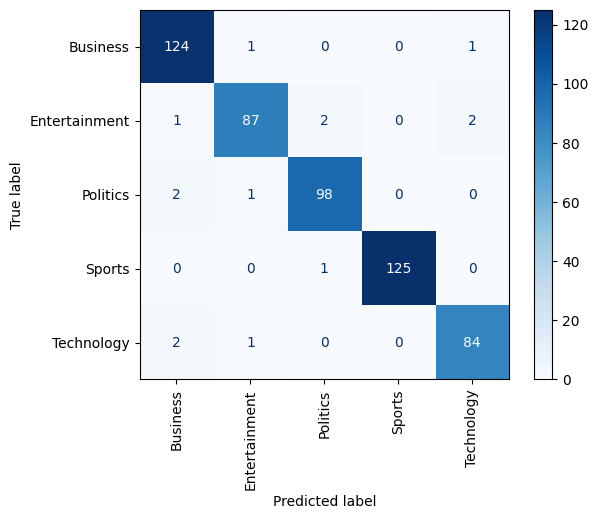

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       126
           1       0.97      0.95      0.96        92
           2       0.97      0.97      0.97       101
           3       1.00      0.99      1.00       126
           4       0.97      0.97      0.97        87

    accuracy                           0.97       532
   macro avg       0.97      0.97      0.97       532
weighted avg       0.97      0.97      0.97       532



In [60]:
NB_model = MultinomialNB(class_prior=class_weights)
model_check(NB_model, X_train, X_test, y_train, y_test, class_names, method='freq', n_grams=(1,1))

#### TF-IDF Vectorizer

Model Performance:
Test Accuracy: 96.43 %
Confusion Matrix:


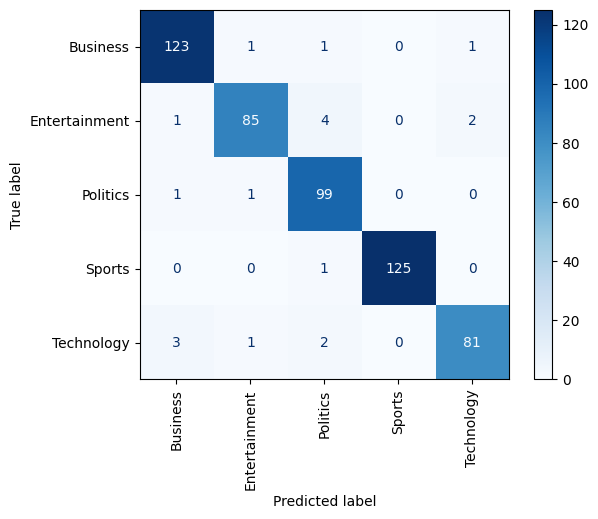

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       126
           1       0.97      0.92      0.94        92
           2       0.93      0.98      0.95       101
           3       1.00      0.99      1.00       126
           4       0.96      0.93      0.95        87

    accuracy                           0.96       532
   macro avg       0.96      0.96      0.96       532
weighted avg       0.96      0.96      0.96       532



In [61]:
NB_model = MultinomialNB(class_prior=class_weights)
model_check(NB_model, X_train, X_test, y_train, y_test, class_names, method='tf_idf', n_grams=(1,1))

### DecisionTree

#### CountVectorizer

Model Performance:
Test Accuracy: 83.08 %
Confusion Matrix:


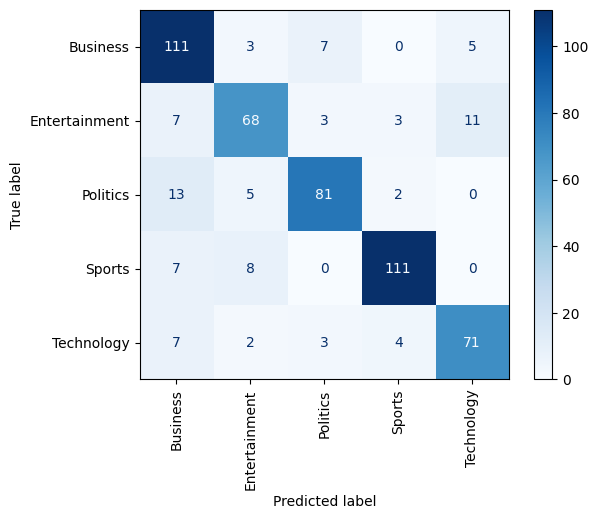

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       126
           1       0.79      0.74      0.76        92
           2       0.86      0.80      0.83       101
           3       0.93      0.88      0.90       126
           4       0.82      0.82      0.82        87

    accuracy                           0.83       532
   macro avg       0.83      0.82      0.83       532
weighted avg       0.83      0.83      0.83       532



In [62]:
DT_model = DecisionTreeClassifier(class_weight=dict(zip(class_labels, class_weights)))
model_check(DT_model, X_train, X_test, y_train, y_test, class_names, method='freq', n_grams=(1,1))

#### TF-IDF Vectorizer

Model Performance:
Test Accuracy: 79.89 %
Confusion Matrix:


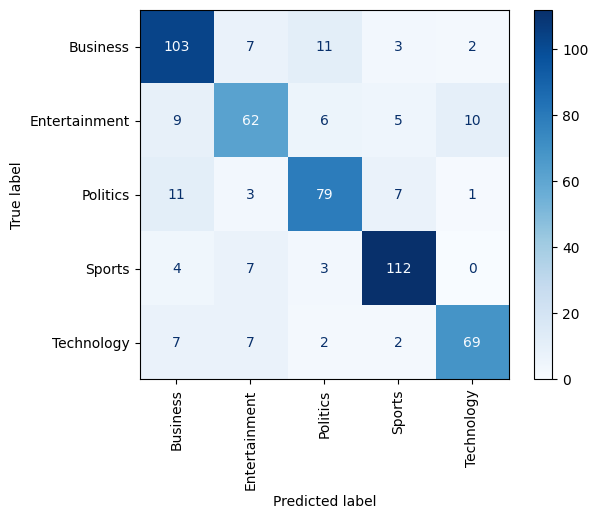

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       126
           1       0.72      0.67      0.70        92
           2       0.78      0.78      0.78       101
           3       0.87      0.89      0.88       126
           4       0.84      0.79      0.82        87

    accuracy                           0.80       532
   macro avg       0.80      0.79      0.79       532
weighted avg       0.80      0.80      0.80       532



In [63]:
DT_model = DecisionTreeClassifier(class_weight=dict(zip(class_labels, class_weights)))
model_check(DT_model, X_train, X_test, y_train, y_test, class_names, method='tf_idf', n_grams=(1,1))

### Nearest Neighbors

#### CountVectorizer

Model Performance:
Test Accuracy: 61.84 %
Confusion Matrix:


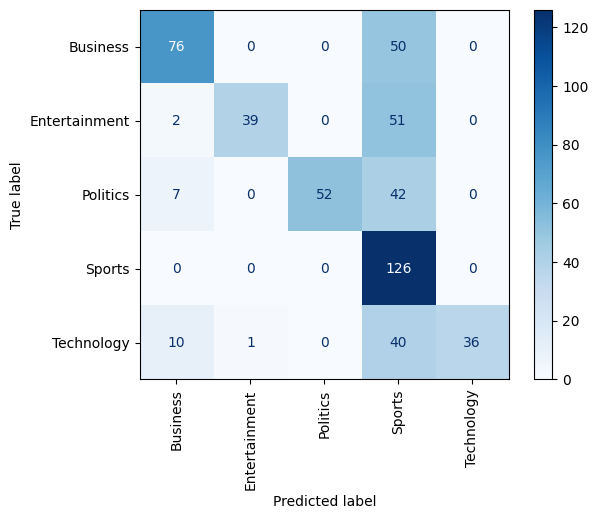

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.60      0.69       126
           1       0.97      0.42      0.59        92
           2       1.00      0.51      0.68       101
           3       0.41      1.00      0.58       126
           4       1.00      0.41      0.59        87

    accuracy                           0.62       532
   macro avg       0.84      0.59      0.62       532
weighted avg       0.81      0.62      0.63       532



In [64]:
K = 5
KNN_model = KNeighborsClassifier(n_neighbors=K)
model_check(KNN_model, X_train, X_test, y_train, y_test, class_names, method='freq', n_grams=(1,1))

#### TF-IDF Vectorizer

Model Performance:
Test Accuracy: 95.49 %
Confusion Matrix:


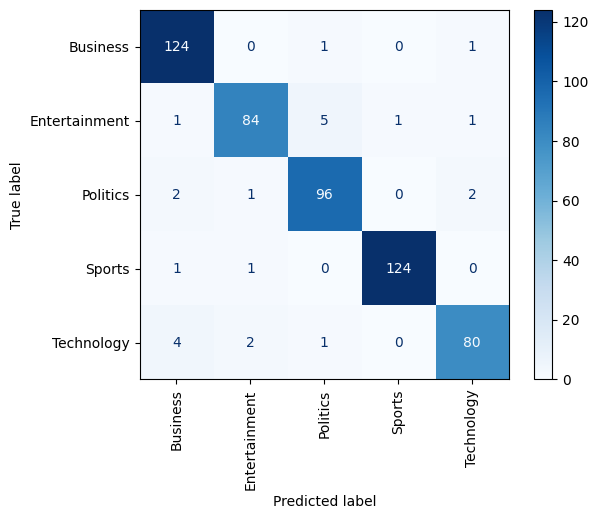

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       126
           1       0.95      0.91      0.93        92
           2       0.93      0.95      0.94       101
           3       0.99      0.98      0.99       126
           4       0.95      0.92      0.94        87

    accuracy                           0.95       532
   macro avg       0.95      0.95      0.95       532
weighted avg       0.96      0.95      0.95       532



In [65]:
K = 5
KNN_model = KNeighborsClassifier(n_neighbors=K)
model_check(KNN_model, X_train, X_test, y_train, y_test, class_names, method='tf_idf', n_grams=(1,1))

### Random Forest

#### CountVectorizer

Model Performance:
Test Accuracy: 95.49 %
Confusion Matrix:


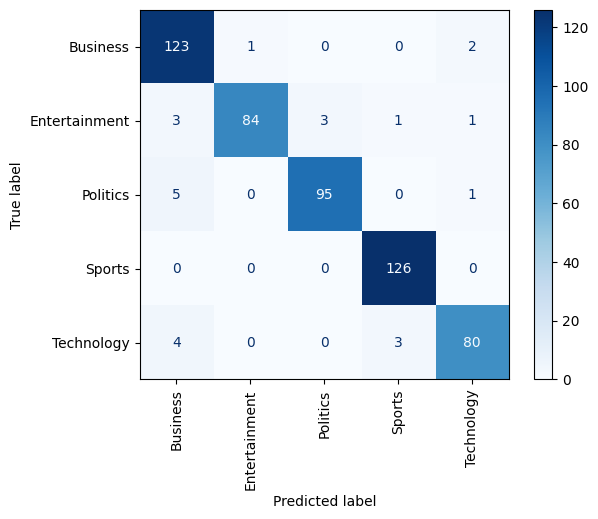

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       126
           1       0.99      0.91      0.95        92
           2       0.97      0.94      0.95       101
           3       0.97      1.00      0.98       126
           4       0.95      0.92      0.94        87

    accuracy                           0.95       532
   macro avg       0.96      0.95      0.95       532
weighted avg       0.96      0.95      0.95       532



In [66]:
RF_model = RandomForestClassifier(class_weight=dict(zip(class_labels, class_weights)))
model_check(RF_model, X_train, X_test, y_train, y_test, class_names, method='freq', n_grams=(1,1))

#### TF-IDF Vectorizer

Model Performance:
Test Accuracy: 94.55 %
Confusion Matrix:


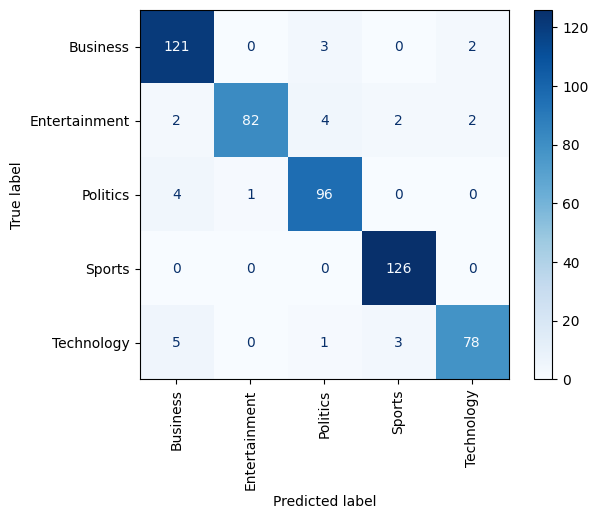

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       126
           1       0.99      0.89      0.94        92
           2       0.92      0.95      0.94       101
           3       0.96      1.00      0.98       126
           4       0.95      0.90      0.92        87

    accuracy                           0.95       532
   macro avg       0.95      0.94      0.94       532
weighted avg       0.95      0.95      0.95       532



In [70]:
RF_model = RandomForestClassifier(class_weight=dict(zip(class_labels, class_weights)))
model_check(RF_model, X_train, X_test, y_train, y_test, class_names, method='tf_idf', n_grams=(1,1))

## Observations on model performance

1. We achieved test accuracy of 97% for **Naive Bayes model** with CountVectorizer & 96% with TF-IDF vectorizer
2. We achieved test accuracy of 83% for **Decision Tress** model with CountVectorizer & 80% with TF-IDF vectorizer
3. We achieved test accuracy of 62% for **KNN** model with CountVectorizer & 95% with TF-IDF vectorizer
3. We achieved test accuracy of 95% for **Random Forest** model with CountVectorizer & 95% with TF-IDF vectorizer

## Questionnaire

### How many news articles are present in the dataset that we have?

*Ans: There are 2225 news articles present in given dataset but out of which 99 are duplicates so that gives us only 2126 unique news articles*

### Most of the news articles are from _____ category.

*Ans: Sport category shows highest news articles (504)*

### Only ___ no. of articles belong to the ‘Technology’ category.

*Ans: 347 news articles belong to the ‘Technology’ category*

### What are Stop Words and why should they be removed from the text data?

Ans: 

Stop words are common words that do not carry significant meaning in a given language. Examples of stop words in English include "a," "an," "the," "is," "and," "but," etc. These words are considered to be noise in the text and are often removed during the preprocessing step in natural language processing tasks.

There are several reasons for removing stop words from text data:

1. Noise reduction: Stop words appear frequently in text but do not contribute much to the overall meaning or context. By removing them, we reduce the noise in the data, making it easier to focus on the more important words.

2. Storage and memory efficiency: Stop words are typically very common words, and removing them reduces the size of the text data, resulting in more efficient storage and memory usage.

3. Improved performance: Removing stop words can enhance the performance of text analysis tasks such as text classification, information retrieval, and sentiment analysis. Stop words often do not provide valuable insights and removing them can improve the accuracy and efficiency of these algorithms.

4. Focus on content words: By eliminating stop words, the emphasis is placed on content words, which carry more meaningful information. This can be especially important in tasks like keyword extraction, topic modeling, or document clustering, where the goal is to identify the most important terms or concepts.

### Explain the difference between Stemming and Lemmatization.

Ans:

Both stemming and lemmatization are techniques used in natural language processing (NLP) to reduce words to their base or root form. The main difference between stemming and lemmatization lies in their approach and the level of abstraction they provide.

**1. Stemming:**
Stemming is a simple and heuristic-based approach that chops off prefixes or suffixes from words to obtain their root or base form. The resulting stem may not always be a valid word in the language. For example:
- Running -> Run
- Jumps -> Jump
- Happily -> Happi

Stemming algorithms are generally faster and less computationally intensive because they use simple string manipulation rules to transform words. However, they may produce stems that are not actual words and may not always capture the correct base form. Stemming is often used for tasks like information retrieval or indexing, where the exact meaning of the words is not crucial, and speed is essential.

Popular stemming algorithms include Porter Stemmer, Snowball Stemmer, and Lancaster Stemmer.

**2. Lemmatization:**
Lemmatization, on the other hand, is a more advanced and linguistically informed process. It involves reducing words to their base or dictionary form, known as the lemma, while taking into account the word's part of speech (POS) and its meaning in the context. The resulting lemma is always a valid word in the language. For example:
- Running -> Run
- Jumps -> Jump
- Happily -> Happy

Lemmatization requires access to a lexicon or dictionary to map words to their base forms correctly. It considers the grammatical and semantic relationships of words in a sentence, making it more accurate than stemming. Lemmatization is generally slower and more computationally intensive compared to stemming due to its reliance on linguistic analysis.

Lemmatization is often preferred for tasks that require a deeper understanding of the text, such as language generation, sentiment analysis, and machine translation.

In summary, stemming is a faster and less accurate technique that chops off prefixes and suffixes to obtain word stems, while lemmatization is a more accurate process that reduces words to their base form, the lemma, considering the word's part of speech and meaning. The choice between stemming and lemmatization depends on the specific NLP task and the level of precision and linguistic detail required.

### Which of the techniques Bag of Words or TF-IDF is considered to be more efficient than the other?

Ans:
    
The efficiency of Bag of Words (BoW) and Term Frequency-Inverse Document Frequency (TF-IDF) depends on the specific use case and the size of the dataset. Both techniques have their advantages and trade-offs.

**1. Bag of Words (BoW):**
BoW is a simple and straightforward technique where a document's content is represented as an unordered collection of words, and the frequency of each word is used as a feature. BoW does not consider the order of words or their context in the document.

Efficiency of BoW:
- BoW is efficient in terms of computation and memory usage, especially when dealing with large datasets. It requires minimal preprocessing and can scale well to large corpora.
- Since BoW only involves counting the occurrences of each word, the feature representation is typically sparse, which can lead to faster processing and memory savings.
- BoW is commonly used in text classification and information retrieval tasks.

However, BoW has limitations:
- It ignores word order and grammar, leading to a loss of sequential and contextual information.
- It treats all words equally, without considering the importance or discriminative power of each word.
- BoW can result in a high-dimensional feature space, especially with a large vocabulary, which can be computationally expensive for some algorithms.

**2. Term Frequency-Inverse Document Frequency (TF-IDF):**
TF-IDF is a more sophisticated technique that aims to address some of the limitations of BoW. It calculates the importance of a word in a document relative to its occurrence in the entire corpus. Words that appear frequently in a document but infrequently across the corpus receive higher weights.

Efficiency of TF-IDF:
- While TF-IDF requires more computational resources than BoW, its efficiency depends on the size of the corpus. For small and medium-sized datasets, TF-IDF can still perform well and provide more meaningful representations.
- TF-IDF assigns higher importance to words that are more discriminative in the context of a specific document, helping to capture more relevant information.
- It can help reduce the impact of common and less informative words (stop words) by downweighting them in the feature representation.

However, TF-IDF has its own limitations:
- TF-IDF still loses contextual information and word order like BoW, as it is based on the individual term's frequency and inverse document frequency.
- For very large corpora, calculating TF-IDF can become computationally expensive and require significant memory resources.

In conclusion, the choice between Bag of Words and TF-IDF depends on the specific requirements of the NLP task, the size of the dataset, and the available computational resources. For large-scale applications or tasks that need to capture more meaningful word representations, TF-IDF can be a better choice despite its additional computational cost. For quick and efficient processing, especially with large datasets, Bag of Words might be preferred due to its simplicity and lower memory requirements.

### What’s the shape of train & test data sets after performing a 75:25 split

Ans:
- Train data shape: (1594,)
- Test data shape: (532,)
- Train labels shape: 1594
- Test labels shape: 532

### Which of the following is found to be the best performing model..

a. Random Forest b. Nearest Neighbors c. Naive Bayes

Ans:
Naive Bayes

### According to this particular use case, both precision and recall are equally important. (T/F)

Ans: T (Class Imbalance)